# Diffuse Fit Workshop #

Manuel Silva 

June 16, 2022


# Prepare the Environment #
* You need all these packages to play around with the data
* [numpy](https://www.numpy.org/) and [scipy](https://www.scipy.org/) are for managing and analyzing the data 
* [matplotlib](https://matplotlib.org/) is good for making plots and visualizing data
* [json](https://pythonbasics.org/json/) is a data structure for storing and sharing data
* Start by importing them!

\\
*if you are not too familiar with these packages, make sure to follow the links and look at some examples

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import json

# Download the dataset #
* Start by downloading the dataset to your machine
  *  /home/icecube-bootcamp/bootcamp2022/diffuse_exercise/hese_toy_data.json
  *  /home/icecube-bootcamp/bootcamp2022/diffuse_exercise/
  hese_toy_simulation.json

# Load the Simulation (eg expected rates) #
* The dataset was saved as a json file
* In the real world, you might use ".i3", ".npy", ".pkl" datasets
  * Follow the example below, for loading the simulation dataset
  
* It is always a good idea to "print" every few lines and make sure the dataset is properly loaded into your python session


In [1]:
json_contents = json.load(open("/home/icecube-bootcamp/bootcamp2022/diffuse_exercise/hese_toy_simulation.json", "r"))
simulation_mapping = json_contents["mapping"]
simulation_events = np.array(json_contents["events"])
del json_contents

NameError: name 'json' is not defined

In [7]:
sim_map = sorted(simulation_mapping.items(), key=lambda x: x[1])
print (sim_map)

[('astroWeight', 0), ('atmoWeight', 1), ('energy', 2), ('primaryEnergy', 3), ('primaryZenith', 4), ('topology', 5), ('zenith', 6)]


In [8]:
print (simulation_events[:2])
[[(k, e[i]) for k, i in sim_map] for e in simulation_events[:2]]

[[1.455e-05 9.797e-06 1.007e+05 1.391e+05 1.581e+00 0.000e+00 1.500e+00]
 [7.289e-06 4.587e-07 3.191e+05 2.485e+05 7.607e-01 0.000e+00 9.098e-01]]


[[('astroWeight', 1.455e-05),
  ('atmoWeight', 9.797e-06),
  ('energy', 100700.0),
  ('primaryEnergy', 139100.0),
  ('primaryZenith', 1.581),
  ('topology', 0.0),
  ('zenith', 1.5)],
 [('astroWeight', 7.289e-06),
  ('atmoWeight', 4.587e-07),
  ('energy', 319100.0),
  ('primaryEnergy', 248500.0),
  ('primaryZenith', 0.7607),
  ('topology', 0.0),
  ('zenith', 0.9098)]]

# Load the Data (eg the observed rates) #
* Follow the same procedure to load the data
  * remember to change the variable names so you don't accidentally overwrite the simulation

# Computing the Expectation Value (eg $\lambda$) #

* Now let's turn on IceCube for 1 year, how many neutrinos do you expect to see?
  * how many neutrinos for energies > 100 TeV?
  * what about zeniths > 90?
* The best way to compute an expectation value is to use Monte Carlo!
* Start by generating neutrinos and "inject" them near IceCube
  * You usually inject neutrinos following chosen energy, zenith, azimuthal distributions, and over a certain area of IceCube (should we inject directly inside IceCube, further away, deepcore only?)

\\
* Since you choose what events we generate (maybe you want high energy neutrinos vs low energy neutrinos), we need to normalize the simulated events
  * Take your ensemble of simulated events and compute a "gen-weight" for every event, refer to this "gen-weight" as a generated flux:
  
  $\Phi_{generated} = N_{generated} [GeV^{-1} * sr^{-1} * cm^{-2}]$
  
* Now choose a theoretical model, either atmospheric or astrophysical flux model, lets proceed with astrophysical for now
  * Take 2 year MESE flux as an example
  
  $\Phi_{model} = \Phi_{MESE} = 2.06 *10^{-18}*(\frac{E_{\nu}}{100TeV})^{-2.46} [s^{-1} * GeV^{-1} * sr^{-1} * cm^{-2}]$
  
\\
* You can now combine the generated flux and theoretical fluxes to compute event rates
  * Each event will now have it's own expectation rate in units $s^{-1}$
  * This is literally the expectation (weight) probability that IceCube "sees" an event exactly like this every second

  $w = \frac{\Phi_{model}}{\Phi_{generated}}$

* $w$ is the expectation value assuming a perfect detector with perfect simulation for that particular event with particular energy/zenith/etc...

# Apply Realistic Weights to the Simulation! #
* After taking into account your event selection, detector effects, etc.... we now denote a weight "i" per event
* If we choose all events from 100 GeV-1 TeV, zenith < 90, cascade topology, the term $w_{i}$ would tell us how many neutrinos we expect in IceCube with these particular properties per second (we refer to this criteria as a bin).

  $w_{i} = \Sigma_{bin-i}\frac{\Phi_{model}}{\Phi_{generated}}$
  
* Since the HESE dataset measures the astrophysical and atmospheric neutrino fluxes, we need to take both expectations into account

  $w_{i,atmos} = \Sigma_{bin-i}\frac{\Phi_{atmos}}{\Phi_{gen,atmos}}$,

  $w_{i,astro} = \Sigma_{bin-i}\frac{\Phi_{astro}}{\Phi_{gen,astro}}$

  $w_{i,total} = w_{i,atmos} + w_{i,astro}$

\\
*  At this point, we are technically done computing our expecation value. 
*  We still need to run our fit to data using simulation (remember our $\Phi_{0}$ scan?)
  

# Let's write some code now... #

* For the atmospheric component, we will add some overall normalization term ($N_{atmos}$)

  $w'_{i,atmos}=N_{atmos}*w_{i,atmos}$

* For the astrophysical component, we will add some overall normalization term ($N_{astro}$) along with an additional energy spectral index term ($\gamma$)
  * scale your simulation by the following: $1.0⋅\frac{E_{\nu}}{100TeV}^{−2.5}$ 
  * why did we do this?

  $w'_{i,astro}=N_{astro}* \frac{E_{\nu}}{100TeV}^{−\gamma}/ \frac{E_{\nu}}{100TeV}^{−2.5} * w_{i,astro}$
  
\\
* look at the simulation you loaded earlier (eg "print simulation_events")
#We gave you the weights!#

* In practice, you will spend a majority of your time setting up these weights yourself. We refer to this as "reweighting" the simulation. But why do we prefer reweighing over resimulation?

* you want to takes these weights and rescale them to different $N_{atmos}$, $N_{astro}$, $\gamma$

* write a python function now 

def weight_event(event, atmos_norm, astro_norm, astro_gamma):

    fill in your code here

# Bin the Data! #
* We can take all the HESE events and run a fit using the maximum likelihood technique you learned yesterday!
  * But remember, there are different detector effects for different energy ranges, zeniths, topologies, so we need to be a little more rigorous here!
*  Let's use energy, zenith, and topology as our observables and create some bins 

*  Start by creating bins for different energy ranges
  *  The HESE dataset is primarily for high energy, E = [60 TeV, 10 PeV]
  *  Do you think log space or linear space is preferable?
*  Now create bins for different zenith ranges
  *  HESE is all sky, $\theta = [0, \pi]$
  *  Do you think we should bin in linear space, log space
  *  What about binning it in $\theta$ vs cos($\theta$)
*  HESE can theoretically measure three different topolgies, but for today lets stick to tracks vs cascades 
  * Create two bins for topology

\\

* Easiest way to create bins is by using "[numpy.logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html)" and "[numpy.linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)"
* When you are done, create a histogram in matplotlib using energy > 60 TeV. Then zenith < 90, etc...


# Bin the Data - Advanced #
* You can use the bins you defined above and apply it to both simulation and data
  * this means that there will now be a set of observed events and expected events, where each bin has its own set of observation and expectations
* What you should now do is for each energy, zenith, topologies bin defined above and scan over all possible $N_{atmos}$, $N_{astro}$, $\gamma$ 
  * As you can see, this has potential to get very memory heavy, very fast, so just use this code to bin the data and simulation

In [5]:
def make_bin_masks(energies, zeniths, topologies,
                   energy_bins=energy_bins, zenith_bins=zenith_bins, topology_bins=topology_bins):
    
    assert(len(energies) == len(zeniths))
    assert(len(energies) == len(topologies))
    
    n_energy_bins = len(energy_bins) - 1
    n_zenith_bins = len(zenith_bins) - 1
    n_topology_bins = len(topology_bins) - 1
    
    energy_mapping = np.digitize(energies, bins=energy_bins) - 1
    zenith_mapping = np.digitize(zeniths, bins=zenith_bins) - 1
    topology_mapping = np.digitize(topologies, bins=topology_bins) - 1
    bin_masks = []
    for i in range(n_topology_bins):
        for j in range(n_zenith_bins):
            for k in range(n_energy_bins):
                mask = topology_mapping == i
                mask = np.logical_and(mask, zenith_mapping == j)
                mask = np.logical_and(mask, energy_mapping == k)
                bin_masks.append(mask)
    return bin_masks
  
bin_masks = make_bin_masks(simulation_events[...,2], simulation_events[...,6], simulation_events[...,5])
data_masks = make_bin_masks(data_events[...,0], data_events[...,2], data_events[...,1])

NameError: name 'energy_bins' is not defined

# Pre-Fit Cross-Checks #
* At this point, you need to make sure that your set of observations and expectations make reasonable sense
* Write a function that takes the events, the bin masks, and our weights
  * Use the following parameters so you can double-check: atmos_norm=1.0, astro_norm=1.0, astro_gamma=2.5

def get_expectation(events, masks, weighting):

    fill in your code here
    
    return np.array("array of expectation value")

# Likelihood Evaluation #
*  Now we define our likelihood function, which will be a poissonian likelihood (like the previous example), the only difference is that the expectation is a bit more complicated, and we have 3 free parameters instead of one.



$\Large \mathcal{L}(\overrightarrow{\theta | d})=\prod_{i} \frac{\left(\lambda_{i}\right)^{k_{i}} e^{-\lambda_{i}}}{k_i!}$



$\Large \log \mathcal{L}(\theta \overrightarrow{ |} d)=\sum_{i} k_{i} \cdot \log \left(\lambda_{i}\right)-\lambda_{i}-\log\Gamma\left[k_{i}+1\right]$

\\

#Write a function to compute the loglikelihood#

\\

def llh(data, simulation_events, atmos_norm, astro_norm, astro_gamma):

    fill in your code here
    
    return loglikelihood

# Test using the data #
* Test the function using the data and some assumed values for your free parameters before you move on
  * Use the following parameters so you can double-check with us: atmos_norm=1.0, astro_norm=1.0, astro_gamma=2.5

# Minimize the llh function#

Earlier today, we used a minimizer for 1 free parameter. Now use the same function, but modify it to fit 3 parameters.

# Check your Final Results #

* "results" contains the output of the fit
* "results.x" contains an array of the best-fit values

In [ ]:
print(results)
print(results.x)

In [ ]:
print ('Atmospheric Normalization = ', results.x[0])
print ('Astrophysical Normalization = ', results.x[1])
print ('Astrophysical Gamma = ', results.x[2])

# Congratulations! #

You have officially completed a 3-dimensional diffuse fit!
Now go have a cup of coffee and relax. 

You're done with bootcamp!!




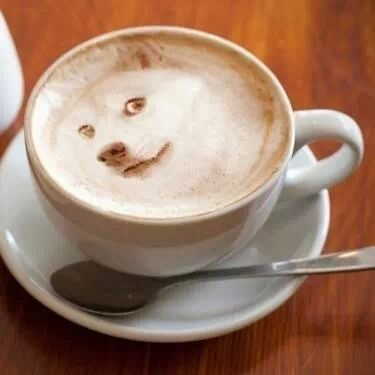